In [34]:
import cv2
import os
import datetime
import time
import numpy as np
import keras
import tensorflow.keras
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers
import tensorflow.keras.backend as K
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.models import Sequential, Model
from sklearn.model_selection import train_test_split
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.applications import ResNet50, ResNet152
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report,confusion_matrix
from tensorflow.keras.layers import Input,UpSampling3D,Dense, Dropout,BatchNormalization 
from tensorflow.keras.layers import SeparableConv2D, Activation,DepthwiseConv2D,Flatten,concatenate
from tensorflow.keras.layers import Conv2D, MaxPooling2D,GlobalAveragePooling2D,Conv2DTranspose, Concatenate
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.callbacks import LearningRateScheduler,ModelCheckpoint

In [35]:
labels = ['HSIL', 'LSIL', 'Normal', 'SCC']
class_info = {0: 'HSIL', 1: 'LSIL',2: 'Normal',3: 'SCC'}
img_size = 224

In [36]:
import glob
filename = glob.glob('/kaggle/input/augmentedmendley-and-local/Augmentedmendleylocal/HSIL/*.*')
print(len(filename))
filename = glob.glob('/kaggle/input/augmentedmendley-and-local/Augmentedmendleylocal/LSIL/*.*')
print(len(filename))
filename = glob.glob('/kaggle/input/augmentedmendley-and-local/Augmentedmendleylocal/Normal/*.*')
print(len(filename))
filename = glob.glob('/kaggle/input/augmentedmendley-and-local/Augmentedmendleylocal/SCC/*.*')
print(len(filename))


300
300
300
300


In [58]:
BATCH_SIZE = 16
IMG_SIZE = (299, 299)


In [71]:
def get_data(data_dir, img_size=299):
    x, y = [], []
    
    # List of supported image file extensions
    supported_extensions = ('.bmp','.jpg')
    
    for label in os.listdir(data_dir):
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        
        for img in os.listdir(path):
            try:
                # Check if the file has a supported image extension
                if img.lower().endswith(supported_extensions):
                    img_arr = cv2.imread(os.path.join(path, img))
                    img_arr = cv2.cvtColor(img_arr, cv2.COLOR_BGR2RGB)
                    resized_arr = cv2.resize(img_arr, (img_size, img_size), interpolation=cv2.INTER_LINEAR)
                    x.append(resized_arr)
                    y.append(class_num)
            except Exception as e:
                print(e)
    
    return x, y


In [72]:
data_x, data_y = get_data('/kaggle/input/augmentedmendley-and-local/Augmentedmendleylocal')
from sklearn.model_selection import train_test_split
Train_x, Val_x, Train_y, Val_y = train_test_split(data_x, data_y, test_size=0.2)

In [74]:
Train_x, test_x, Train_y, test_y = train_test_split(Train_x, Train_y, test_size=0.1)

In [75]:
Train_x = np.array(Train_x)
Train_y = np.array(Train_y)
Val_x = np.array(Val_x)
Val_y = np.array(Val_y)
test_x = np.array(test_x)
test_y = np.array(test_y)

In [76]:
train_datagen = ImageDataGenerator()
val_datagen= ImageDataGenerator()
test_datagen = ImageDataGenerator()

In [77]:
Train_gen  = train_datagen.flow(Train_x, Train_y)
val_gen  = val_datagen.flow(Val_x, Val_y)
test_gen = test_datagen.flow(test_x, test_y)

Text(0.5, 1.0, 'Normal')

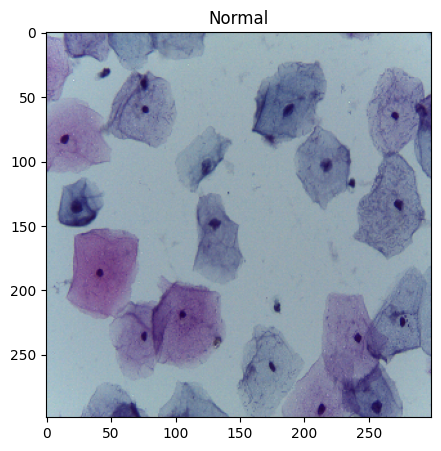

In [78]:
plt.figure(figsize = (5,5))
plt.imshow(Train_x[0])
plt.title(labels[Train_y[0]])

In [79]:
print(Train_x.shape)
print(Val_x.shape)
print(test_x.shape)

(777, 299, 299, 3)
(240, 299, 299, 3)
(87, 299, 299, 3)


In [46]:
# import tensorflow as tf
# from tensorflow.keras.layers import Input, Conv2D, SeparableConv2D, GlobalAveragePooling2D, Dense, MaxPooling2D
# from tensorflow.keras.models import Model

# def build_model(input_shape, num_classes):
#     # Input layer
#     inputs = Input(shape=input_shape)

#     # Entry Flow
#     x = Conv2D(32, (3, 3), strides=(2, 2), activation='relu')(inputs)
#     x = SeparableConv2D(64, (3, 3), activation='relu', padding='same')(x)
   
#     # Middle Flow  
#     for _ in range(8):
#         residual = x
#         x = SeparableConv2D(64, (3, 3), activation='relu', padding='same')(x)
#         x = SeparableConv2D(64, (3, 3), activation='relu', padding='same')(x)
#         x = tf.keras.layers.Add()([x, residual])

#     # Exit Flow
#     x = SeparableConv2D(128, (3, 3), activation='relu', padding='same')(x)
#     x = GlobalAveragePooling2D()(x)

#     # Classification Layers
#     x = Dense(256, activation='relu')(x)
#     outputs = Dense(4, activation='softmax')(x)

#     model = Model(inputs, outputs)

#     return model

# input_shape = (299, 299, 3)  
# num_classes = 4  

# model = build_model(input_shape, num_classes)



In [47]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, SeparableConv2D, GlobalAveragePooling2D, Dense, MaxPooling2D
from tensorflow.keras.models import Model

def build_model(input_shape, num_classes):
    # Input layer
    inputs = Input(shape=input_shape)

    # Entry Flow
    x = Conv2D(32, (3, 3), strides=(2, 2), activation='relu')(inputs)
    x = BatchNormalization()(x)  # Batch normalization layer
    x = Conv2D(64, (3, 3), strides=(2, 2), activation='relu')(inputs)
    x = BatchNormalization()(x)  # Batch normalization layer
    x = SeparableConv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((3, 3), strides=(2, 2))(x)
   
    # Middle Flow  
    for _ in range(8):
        residual = x
        x = SeparableConv2D(128, (3, 3), activation='relu', padding='same')(x)
        x = BatchNormalization()(x)  # Batch normalization layer
        x = SeparableConv2D(128, (3, 3), activation='relu', padding='same')(x)
        x = BatchNormalization()(x)  # Batch normalization layer
        x = tf.keras.layers.Add()([x, residual])

    # Exit Flow
    x = SeparableConv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = GlobalAveragePooling2D()(x)

    # Classification Layers
    x = Dense(512, activation='relu')(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs, outputs)

    return model

input_shape = (299, 299, 3)  
num_classes = 4  

model = build_model(input_shape, num_classes)



In [48]:
model = build_model(input_shape=(299,299,3), num_classes=4)
model.compile(optimizer= tf.keras.optimizers.Adam(learning_rate=0.0001),
                         loss='sparse_categorical_crossentropy',
                         metrics=['accuracy'])
model.summary() 

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_16 (InputLayer)          [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_33 (Conv2D)             (None, 149, 149, 64  1792        ['input_16[0][0]']               
                                )                                                                 
                                                                                                  
 batch_normalization_182 (Batch  (None, 149, 149, 64  256        ['conv2d_33[0][0]']              
 Normalization)                 )                                                           

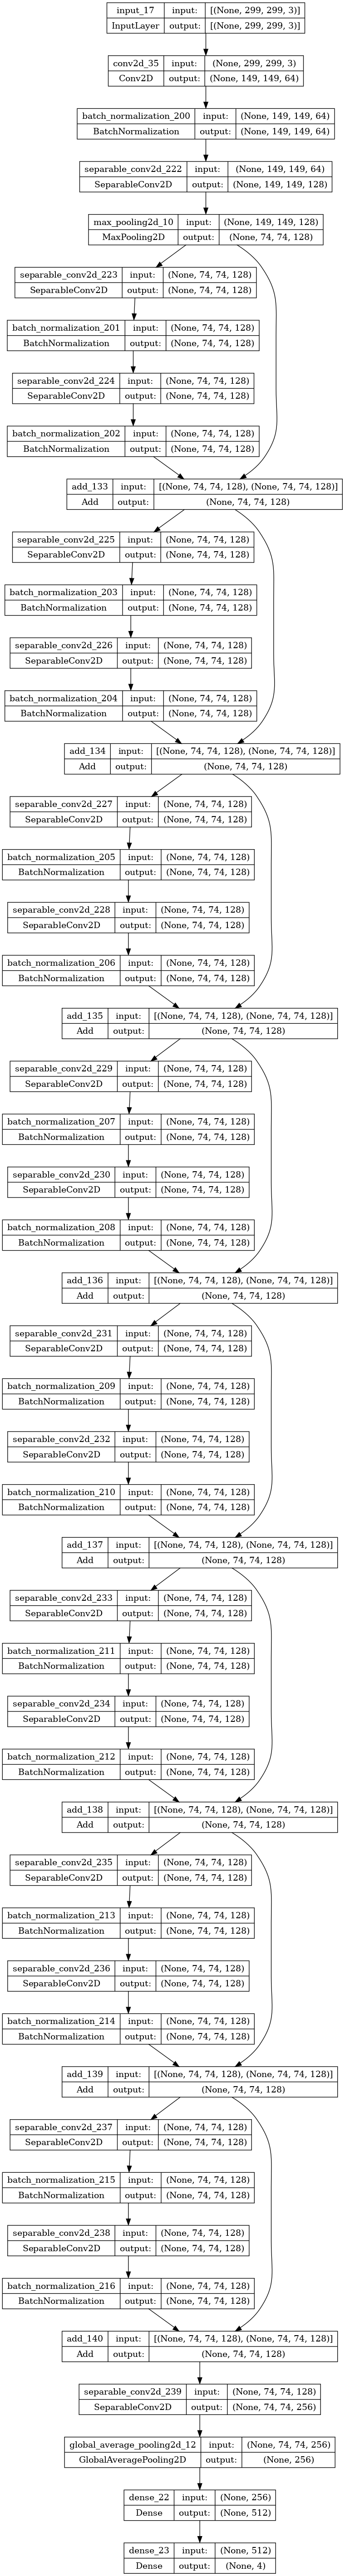

In [49]:
import tensorflow as tf
from tensorflow.keras.utils import plot_model

# Lightweight Xception model for image classification
input_shape = (299, 299, 3)  
num_classes = 4  
light_xception_classification = build_model(input_shape, num_classes)
plot_model(light_xception_classification, to_file='light_xception_classification.png', show_shapes=True, show_layer_names=True)


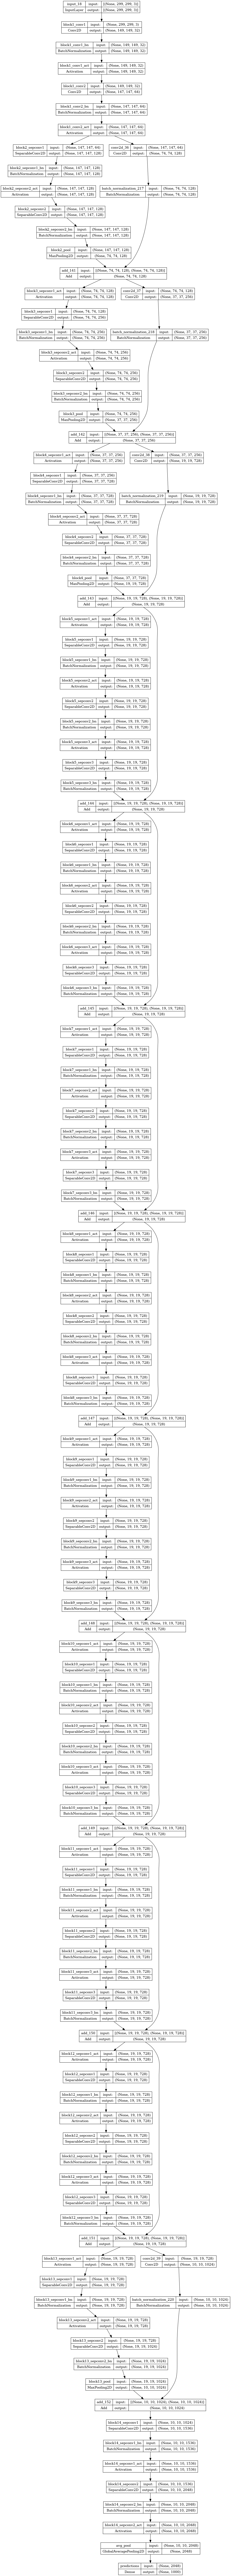

In [50]:
# Original Xception model
original_xception = tf.keras.applications.Xception(weights='imagenet', include_top=True)
plot_model(original_xception, to_file='original_xception.png', show_shapes=True, show_layer_names=True)


In [51]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
callback = [
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.3, patience=3, verbose=1, min_lr=1e-8 ),
    tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1),
    tf.keras.callbacks.ModelCheckpoint(
        filepath='mendeley/classification_weights.{epoch:02d}-{val_loss:.2f}.hdf5',
        save_best_only=True,save_weights_only=True,verbose=1)
           ]

In [52]:
history = model.fit(Train_gen,
                    validation_data = val_gen,
                    epochs=300,
                    batch_size = 8,
                   callbacks=callback)
model.save('mendeleyandlocalclassification.h5')

Epoch 1/300
27/27 [==============================] - ETA: 0s - loss: 1.2198 - accuracy: 0.5741
Epoch 1: val_loss improved from inf to 1.39146, saving model to mendeley/classification_weights.01-1.39.hdf5
27/27 [==============================] - 22s 241ms/step - loss: 1.2198 - accuracy: 0.5741 - val_loss: 1.3915 - val_accuracy: 0.2333 - lr: 1.0000e-04
Epoch 2/300
27/27 [==============================] - ETA: 0s - loss: 0.7806 - accuracy: 0.7766
Epoch 2: val_loss did not improve from 1.39146
27/27 [==============================] - 6s 218ms/step - loss: 0.7806 - accuracy: 0.7766 - val_loss: 1.3944 - val_accuracy: 0.2708 - lr: 1.0000e-04
Epoch 3/300
27/27 [==============================] - ETA: 0s - loss: 0.4785 - accuracy: 0.8391
Epoch 3: val_loss did not improve from 1.39146
27/27 [==============================] - 6s 218ms/step - loss: 0.4785 - accuracy: 0.8391 - val_loss: 1.3978 - val_accuracy: 0.3000 - lr: 1.0000e-04
Epoch 4/300
27/27 [==============================] - ETA: 0s - loss

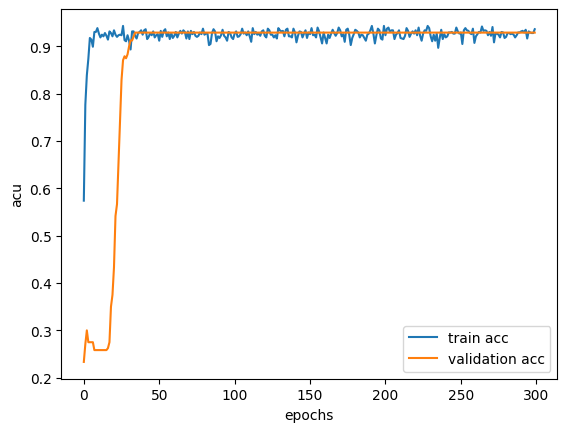

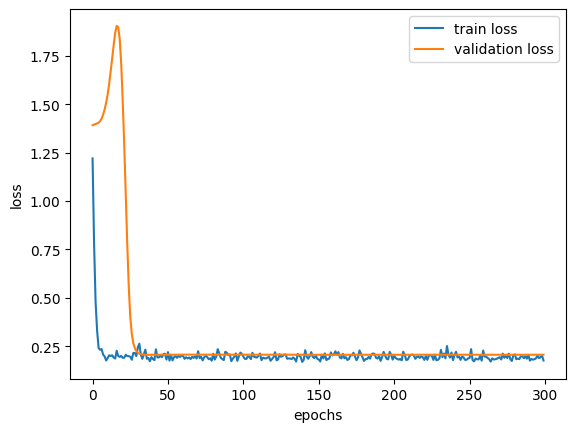

In [53]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['train acc','validation acc'])
plt.ylabel('acu')
plt.xlabel('epochs')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history[ 'val_loss'])
plt.legend(['train loss','validation loss'])
plt.ylabel('loss')
plt.xlabel('epochs')
plt.show()


In [81]:
BATCH = 4
test_dataset = test_datagen.flow(test_x, test_y)

test_steps = (len(test_x)//BATCH)
if len(test_x) % BATCH != 0:
    test_steps += 1


model.evaluate(test_dataset, steps=test_steps)

22/22 [==============================] - 0s 10ms/step - loss: 0.1651 - accuracy: 0.9425


[0.1650521606206894, 0.9425287246704102]

In [80]:
predictions = model.predict(test_x)

3/3 [==============================] - 1s 226ms/step


3/3 [==============================] - 0s 84ms/step


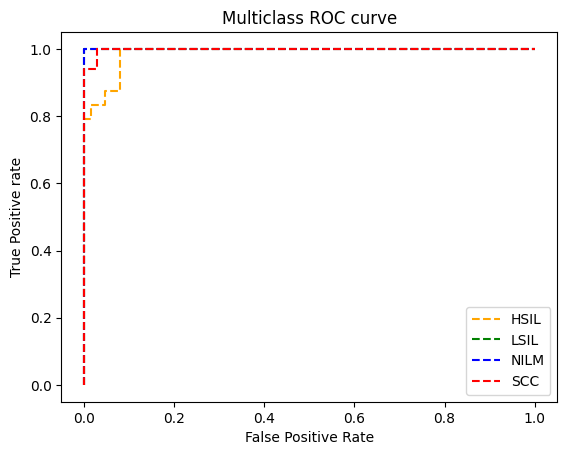

In [82]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
pred_prob = model.predict(test_x)
# pred_prob = restnet.predict_proba(Val_x)

# roc curve for classes
fpr = {}
tpr = {}
thresh ={}

n_class = 4

for i in range(n_class):
    fpr[i], tpr[i], thresh[i] = roc_curve(test_y, pred_prob[:,i], pos_label=i)


plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label='HSIL')
plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='LSIL')
plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label='NILM')
plt.plot(fpr[3], tpr[3], linestyle='--',color='red', label='SCC')

plt.title('Multiclass ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('Multiclass ROC',dpi=300);

In [83]:
for idx in range(len(model.layers)):
  print(model.get_layer(index = idx).name)

# we picked `block5c_project_con` layer 

input_16
conv2d_33
batch_normalization_182
separable_conv2d_204
max_pooling2d_9
separable_conv2d_205
batch_normalization_183
separable_conv2d_206
batch_normalization_184
add_125
separable_conv2d_207
batch_normalization_185
separable_conv2d_208
batch_normalization_186
add_126
separable_conv2d_209
batch_normalization_187
separable_conv2d_210
batch_normalization_188
add_127
separable_conv2d_211
batch_normalization_189
separable_conv2d_212
batch_normalization_190
add_128
separable_conv2d_213
batch_normalization_191
separable_conv2d_214
batch_normalization_192
add_129
separable_conv2d_215
batch_normalization_193
separable_conv2d_216
batch_normalization_194
add_130
separable_conv2d_217
batch_normalization_195
separable_conv2d_218
batch_normalization_196
add_131
separable_conv2d_219
batch_normalization_197
separable_conv2d_220
batch_normalization_198
add_132
separable_conv2d_221
global_average_pooling2d_11
dense_20
dense_21


In [84]:
def decode_prediction(pred):
  # This function thresholds a probability to produce a prediction
  pred = tf.where(pred < 0.5, 0, 1)
  return pred.numpy()

class_label_idx =  3
1/1 [==============================] - 0s 85ms/step
['HSIL', 'LSIL', 'NILM', 'SCC']


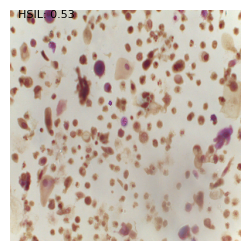

In [85]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

img = test_x[78]
label = test_y[78]
print('class_label_idx = ', label)
# Make predictions for the input image
predictions = model.predict(np.expand_dims(img, axis=0))[0]
N = 1
# Get the top N predicted classes and their probabilities
top_classes = np.argsort(predictions)[-N:][::-1]
top_probs = predictions[top_classes]

class_labels = ['HSIL', 'LSIL', 'NILM', 'SCC']
print (class_labels)
# Display the image
plt.figure(figsize=(3, 3))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis('off')

# Display the top predicted classes and their probabilities
for i in range(len(top_classes)):
    class_idx = top_classes[i]
    class_prob = top_probs[i]
    class_label = class_labels[class_idx]
    plt.text(10, 10 + i * 20, f"{class_label}: {class_prob:.2f}", color='Black', fontsize=8)

plt.show()


['HSIL', 'LSIL', 'NILM', 'SCC']
class_Truelabel_idx =  3
1/1 [==============================] - 0s 20ms/step
class_Truelabel_idx =  1
1/1 [==============================] - 0s 19ms/step
class_Truelabel_idx =  0
1/1 [==============================] - 0s 20ms/step
class_Truelabel_idx =  1
1/1 [==============================] - 0s 19ms/step
class_Truelabel_idx =  1
1/1 [==============================] - 0s 20ms/step
class_Truelabel_idx =  0
1/1 [==============================] - 0s 19ms/step
class_Truelabel_idx =  3
1/1 [==============================] - 0s 20ms/step
class_Truelabel_idx =  0
1/1 [==============================] - 0s 19ms/step
class_Truelabel_idx =  1
1/1 [==============================] - 0s 18ms/step
class_Truelabel_idx =  3
1/1 [==============================] - 0s 19ms/step


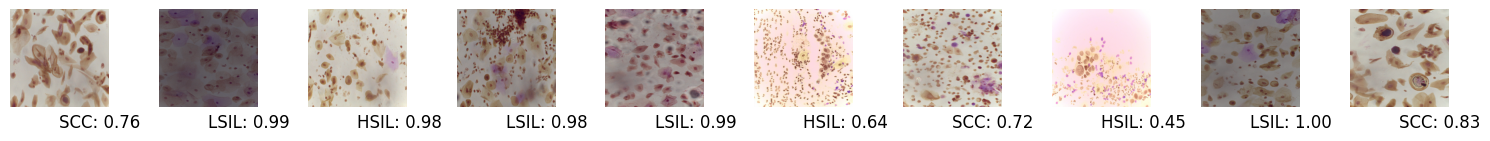

In [86]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Define a list of images and their corresponding labels
images = test_x[0:10]
labels = test_y[0:10]
class_labels = ['HSIL', 'LSIL', 'NILM', 'SCC']  # Define your class labels
print (class_labels)
# Create a subplot grid
rows = 1  # Only one row for horizontal display
cols = len(images)  # One column per image

plt.figure(figsize=(15, 5))  # Adjust the figure size as needed

# Iterate through each image and label
for i in range(len(images)):
    img = images[i]
    label = labels[i]
    print('class_Truelabel_idx = ', label)
    # Make predictions for the input image
    predictions = model.predict(np.expand_dims(img, axis=0))[0]
    N = 1  # Number of top classes to display

    # Get the top N predicted classes and their probabilities
    top_classes = np.argsort(predictions)[-N:][::-1]
    top_probs = predictions[top_classes]

    # Create a subplot for each image
    plt.subplot(rows, cols, i + 1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')

    # Display the top predicted classes and their probabilities below the image
    for j in range(len(top_classes)):
        class_idx = top_classes[j]
        class_prob = top_probs[j]
        class_label = class_labels[class_idx]
        plt.text(0.5, -0.2 - j * 0.2, f"{class_label}: {class_prob:.2f}", color='Black', fontsize=12,
                 transform=plt.gca().transAxes)

plt.tight_layout()
plt.show()


In [87]:
from tensorflow.keras.models import Model



def GradCam(model, img_array, layer_name, eps=1e-8):
    '''
    Creates a grad-cam heatmap given a model and a layer name contained with that model
    

    Args:
      model: tf model
      img_array: (img_width x img_width) numpy array
      layer_name: str


    Returns 
      uint8 numpy array with shape (img_height, img_width)

    '''

    gradModel = Model(
			inputs=[model.inputs],
			outputs=[model.get_layer(layer_name).output,
				model.output])
    
    with tf.GradientTape() as tape:
			# cast the image tensor to a float-32 data type, pass the
			# image through the gradient model, and grab the loss
			# associated with the specific class index
      inputs = tf.cast(img_array, tf.float32)
      (convOutputs, predictions) = gradModel(inputs)
      loss = predictions[:, 0]
		# use automatic differentiation to compute the gradients
    grads = tape.gradient(loss, convOutputs)
    
    # compute the guided gradients
    castConvOutputs = tf.cast(convOutputs > 0, "float32")
    castGrads = tf.cast(grads > 0, "float32")
    guidedGrads = castConvOutputs * castGrads * grads
		# the convolution and guided gradients have a batch dimension
		# (which we don't need) so let's grab the volume itself and
		# discard the batch
    convOutputs = convOutputs[0]
    guidedGrads = guidedGrads[0]
    # compute the average of the gradient values, and using them
		# as weights, compute the ponderation of the filters with
		# respect to the weights
    weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
    cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)
  
    # grab the spatial dimensions of the input image and resize
		# the output class activation map to match the input image
		# dimensions
    (w, h) = (img_array.shape[2], img_array.shape[1])
    heatmap = cv2.resize(cam.numpy(), (w, h))
		# normalize the heatmap such that all values lie in the range
		# [0, 1], scale the resulting values to the range [0, 255],
		# and then convert to an unsigned 8-bit integer
    numer = heatmap - np.min(heatmap)
    denom = (heatmap.max() - heatmap.min()) + eps
    heatmap = numer / denom
    # heatmap = (heatmap * 255).astype("uint8")
		# return the resulting heatmap to the calling function
    return heatmap


def sigmoid(x, a, b, c):
    return c / (1 + np.exp(-a * (x-b)))

def superimpose(img_bgr, cam, thresh, emphasize=False):
    
    '''
    Superimposes a grad-cam heatmap onto an image for model interpretation and visualization.
    

    Args:
      image: (img_width x img_height x 3) numpy array
      grad-cam heatmap: (img_width x img_width) numpy array
      threshold: float
      emphasize: boolean

    Returns 
      uint8 numpy array with shape (img_height, img_width, 3)

    '''
    heatmap = cv2.resize(cam, (img_bgr.shape[1], img_bgr.shape[0]))
    if emphasize:
        heatmap = sigmoid(heatmap, 50, thresh, 1)
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    
    hif = .8
    superimposed_img = heatmap * hif + img_bgr
    superimposed_img = np.minimum(superimposed_img, 255.0).astype(np.uint8)  # scale 0 to 255  
    superimposed_img_rgb = cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB)
    
    return superimposed_img_rgb

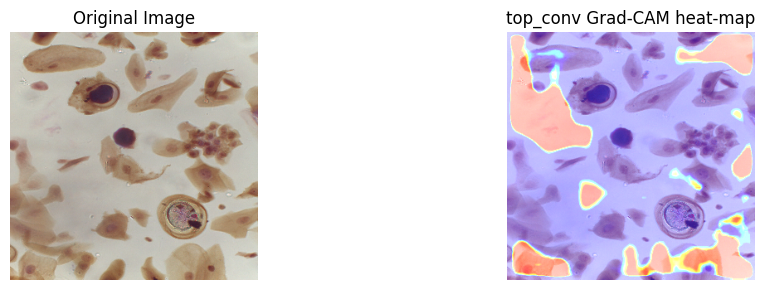

In [90]:
## Grad-CAM heatmap for the last convolutional layer in the model, Conv_1

layer_name = 'separable_conv2d_221'
grad_cam=GradCam(model,np.expand_dims(img, axis=0),layer_name)
grad_cam_superimposed = superimpose(img, grad_cam, 0.5, emphasize=True)


plt.figure(figsize=(12, 3))
ax = plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title('Original Image')
ax = plt.subplot(1, 2, 2)
plt.imshow(grad_cam_superimposed)
plt.axis('off')
plt.title('top_conv Grad-CAM heat-map')
plt.tight_layout()


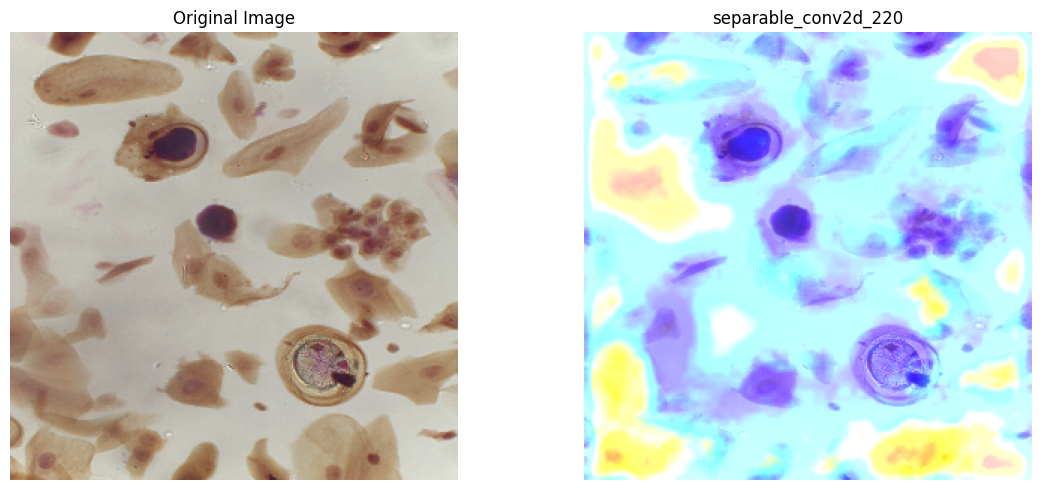

In [93]:
## Grad-CAM heatmap for the block_4_expand_relu
## This layer shows how the model begins learning concepts in the image

plt.figure(figsize=(12, 5))
ax = plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title('Original Image')
ax = plt.subplot(1, 2, 2)
grad_cam = GradCam(model, np.expand_dims(img, axis=0), 'separable_conv2d_220')
grad_cam_emphasized = superimpose(img, grad_cam, 0.5, emphasize=False)
plt.imshow(grad_cam_emphasized)
plt.axis('off')
plt.title('separable_conv2d_220')
plt.tight_layout()


In [ ]:
## Grad-CAM heatmap for the block_4_expand_relu
## This layer shows how the model begins learning concepts in the image

plt.figure(figsize=(12, 5))
ax = plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title('Original Image')
ax = plt.subplot(1, 2, 2)
grad_cam = GradCam(model, np.expand_dims(img, axis=0), 'Conv_1')
grad_cam_emphasized = superimpose(img, grad_cam, 0.5, emphasize=False)
plt.imshow(grad_cam_emphasized)
plt.axis('off')
plt.title('Conv_1')
plt.tight_layout()


Accuracy: 0.942529
Precision: 0.952438
Recall: 0.942529
F1 score: 0.940285
Cohen's kappa: 0.922446
Confusion Matrix:
[[24  0  0  0]
 [ 0 24  0  0]
 [ 0  0 22  0]
 [ 5  0  0 12]]


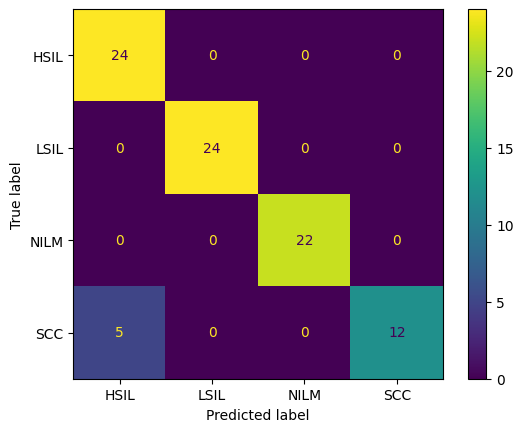

In [95]:
# Import necessary libraries
import numpy as np
from sklearn.metrics import accuracy_score, precision_score,ConfusionMatrixDisplay, recall_score, f1_score, cohen_kappa_score, confusion_matrix
from keras.models import Sequential
from keras.layers import Dense

# Assuming you have already trained and have your model defined as 'model'

# Predict probabilities for test set
yhat_probs = model.predict(test_x, verbose=0)

# Predict crisp classes for test set by selecting the class with the highest probability
yhat_classes = np.argmax(yhat_probs, axis=1)

# Accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(test_y, yhat_classes)
print('Accuracy: %f' % accuracy)

# Precision: tp / (tp + fp)
precision = precision_score(test_y, yhat_classes, average='weighted')  # 'weighted' for multi-class
print('Precision: %f' % precision)

# Recall: tp / (tp + fn)
recall = recall_score(test_y, yhat_classes, average='weighted')  # 'weighted' for multi-class
print('Recall: %f' % recall)

# F1 Score: 2 * (precision * recall) / (precision + recall)
f1 = f1_score(test_y, yhat_classes, average='weighted')  # 'weighted' for multi-class
print('F1 score: %f' % f1)

# Cohen's Kappa
kappa = cohen_kappa_score(test_y, yhat_classes)
print('Cohen\'s kappa: %f' % kappa)

# Confusion Matrix
matrix = confusion_matrix(test_y, yhat_classes)
print('Confusion Matrix:')
print(matrix)
disp = ConfusionMatrixDisplay(confusion_matrix=matrix,display_labels=['HSIL', 'LSIL', 'NILM', 'SCC'])
disp.plot()

plt.savefig('confusionmatrix.png')
plt.show()

In [96]:
class_report = classification_report(test_y, yhat_classes)
print('Classification Report:\n', class_report)

Classification Report:
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        24
           1       1.00      1.00      1.00        24
           2       1.00      1.00      1.00        22
           3       1.00      0.71      0.83        17

    accuracy                           0.94        87
   macro avg       0.96      0.93      0.93        87
weighted avg       0.95      0.94      0.94        87



In [ ]:
model.save('mendeleyclassification.h5')